In [43]:
import matplotlib.pyplot as plt
import autograd.numpy as np
import pennylane as qml

The RISQ gate is a single photon quantum gate capable of applying arbitrary unitary transforms. More information in the read-me file.

It consists of 4 elements: 2 single all-pass rings and 2 stacked rings in alternating order. The single photon transformations applied by these elements are represented by scattering matrices.

Stacked ring scattering matrix S_DB is built from 3 matrices describing each coupling point between seperate waveguides

In [44]:
def generate_S_DB(theta_b, theta_t, eta_sqrd, tau_sqrd):
    eta = np.sqrt(eta_sqrd)
    tau = np.sqrt(tau_sqrd)
    kappa = 1j * np.sqrt(1 - tau_sqrd)
    gamma = 1j * np.sqrt(1 - eta_sqrd)

    T_b = generate_transfer(generate_S_b(theta_b, tau, kappa))
    T_t = generate_transfer(generate_S_t(theta_t, tau, kappa))
    T_I = generate_transfer(generate_S_I(eta, gamma))

    # S_DB = T_b * T_I * T_t
    A = T_b.dot(T_I)
    S_DB = np.transpose(generate_scattering(A.dot(T_t)))


    return S_DB


def generate_S_b(theta, tau, kappa):
    t_b = tau

    s_b = -np.conjugate(kappa)*np.exp(-1j * theta/2)

    sPrime_b = kappa*np.exp(-1j * theta/2)

    tPrime_b = tau*np.exp(-1j * theta)

    return np.array([[t_b, sPrime_b], [s_b, tPrime_b]])


def generate_S_t(theta, tau, kappa):
    t_t = tau*np.exp(-1j * theta)

    sPrime_t = -np.conjugate(kappa) * np.exp(-1j * theta/2)

    s_t = kappa*np.exp(-1j * theta/2)

    tPrime_t = tau

    return np.array([[t_t, sPrime_t], [s_t, tPrime_t]])


def generate_S_I(eta, gamma):
    t_I = eta
    sPrime_I = gamma
    s_I = gamma
    tPrime_I = eta

    return np.array([[t_I, sPrime_I], [s_I, tPrime_I]])

def generate_transfer(S):
    a = S[0][0]
    b = S[0][1]
    c = S[1][0]
    d = S[1][1]

    det = np.linalg.det(S)

    return np.array([[1/c, -d/c], [a/c, -det/c]])


def generate_scattering(T):
    a = T[0][0]
    b = T[0][1]
    c = T[1][0]
    d = T[1][1]

    det = np.linalg.det(T)

    return np.array([[c / a, det / a], [1 / a, -b / a]])

PennyLane has a built-in, automatically differentiable phase-shift gate that can be mapped to the scattering matrix defining the all-pass ring. These functions numerically map between their variables

In [45]:
def findAllPassAngle(phaseAngle):
    pennyLaneVal = np.exp(1j*phaseAngle)

    allPassAngle = phaseAngle

    tau = np.sqrt(0.5)
    kappa = 1j * np.sqrt(1 - tau ** 2)
    allPassVal = np.conjugate(1 / (tau - (abs(kappa)**2) * np.exp(-1j * allPassAngle) / (1 - tau * np.exp(-1j * allPassAngle))))
    difference = (allPassVal - pennyLaneVal)


    while(np.absolute(difference) > 0.001):
        allPassAngle = allPassAngle + 0.05
        if(allPassAngle > np.pi):
            allPassAngle = allPassAngle - 2*np.pi
        allPassVal = np.conjugate(1 / (tau - (abs(kappa) ** 2) * np.exp(-1j * allPassAngle) / (1 - tau * np.exp(-1j * allPassAngle))))
        difference = (allPassVal - pennyLaneVal)

    return allPassAngle


def findPhaseAngle(allPassAngle):
    tau = np.sqrt(0.5)
    kappa = 1j * np.sqrt(1 - tau ** 2)
    allPassVal = np.conjugate(1 / (tau - (abs(kappa) ** 2) * np.exp(-1j * allPassAngle) / (1 - tau * np.exp(-1j * allPassAngle))))
    phaseAngle = allPassAngle
    pennyLaneVal = np.exp(1j*phaseAngle)

    difference = (allPassVal - pennyLaneVal)

    while(np.absolute(difference) > 0.001):
        phaseAngle= phaseAngle + 0.01
        if(phaseAngle > np.pi):
            phaseAngle = phaseAngle - 2*np.pi
        pennyLaneVal = np.exp(1j*phaseAngle)
        difference = (allPassVal - pennyLaneVal)
    return phaseAngle

In [46]:
def localPhase(x,y):
    return abs(np.arctan2(y, x))

def cost(x, TargetZ = 0, TargetOffset = 0):
    Z, Y, X = circuit(x)

    PhaseOffset = localPhase(X,Y)

    return np.pi/2 * abs(Z - TargetZ) + abs(PhaseOffset - TargetOffset)

In [47]:
# Define Pennylane device
dev1 = qml.device("default.qubit", wires=3)

# Generate random detuning and coupling values
a = np.random.random(4)
a = a - 0.50
b = np.random.random(4)
b = b - 0.50
detune = np.pi/3 + (np.pi/3)*a
couple = 1/2 + 1/4 * b
print("Detuning values ",detune)
print("Coupling values ", couple)

# Generate the scattering matrices that define the Stacked Rings from the coupling and detuning values
STARR1 = generate_S_DB(detune[0],detune[1],couple[0],couple[1])
STARR2 = generate_S_DB(detune[2],detune[3],couple[2],couple[3])

# Initial all-pass parameters would apply a hadamard in the case of zero error. (detune = pi/3, couple = 1/2)
# findPhaseAngle numerically maps the RISQ all-pass ring detuning variable to pennylanes built-in phaseshift gate
init_params = np.array([findPhaseAngle(0.34), findPhaseAngle(0.0)])

Detuning values  [0.74433692 1.44119553 1.07847714 1.21563143]
Coupling values  [0.47479747 0.56156997 0.47822009 0.42149089]


The single-qubit RISQ gate is defined by a series of 4 unitary transformations.

The single rings are all-pass rings, which apply transformations equivilent to the qml phaseshift gate

The Stacked rings apply a transformation given by generate_S_DB()

In [48]:
# 3 copies of the circuit, 1 per measurment (X,Y,Z)

@qml.qnode(dev1)
def circuit(params):
    
    qml.QubitUnitary(STARR1, wires=0)
    qml.PhaseShift(params[0], wires=0)
    qml.QubitUnitary(STARR2, wires=0)
    qml.PhaseShift(params[1], wires=0)

    qml.QubitUnitary(STARR1, wires=1)
    qml.PhaseShift(params[0], wires=1)
    qml.QubitUnitary(STARR2, wires=1)
    qml.PhaseShift(params[1], wires=1)

    qml.QubitUnitary(STARR1, wires=2)
    qml.PhaseShift(params[0], wires=2)
    qml.QubitUnitary(STARR2, wires=2)
    qml.PhaseShift(params[1], wires=2)




    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliY(1)), qml.expval(qml.PauliX(2))

In [49]:
# initialise the optimizer
opt = qml.AdamOptimizer(stepsize=0.01)
# set the max number of steps
steps = 5000
# set the initial parameter values
params = init_params

# Save initial parameters for later
x = findAllPassAngle(init_params[0])
y = findAllPassAngle(init_params[1])
paramsINIT = np.array([x, y])

# Variable to save cost values for graphical display
Y = np.zeros(steps)


for i in range(steps):
    # update the circuit parameters using the optimizer
    params = opt.step(cost, params)
    Y[i] = cost(params)
    # Display progress every 10 steps
    if (i + 1) % 10 == 0:
        a = qml.math.toarray(params)
        x = findAllPassAngle(a[0])
        y = findAllPassAngle(a[1])
        paramsNP = np.array([x, y])
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
        print("current rotation angles: {}".format(paramsNP))
        print()

    # Stop optimizing if cost is low enough
    if cost(params) < 0.01:
        a = qml.math.toarray(params)
        x = findAllPassAngle(a[0])
        y = findAllPassAngle(a[1])
        paramsNP = np.array([x, y])

        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
        print("current rotation angles: {}".format(paramsNP))
        break

Cost after step    10:  0.5635024
current rotation angles: [ 0.32084035 -0.01015988]

Cost after step    20:  0.4397419
current rotation angles: [ 0.30593161 -0.01840809]

Cost after step    30:  0.3362740
current rotation angles: [ 0.29073779 -0.02594534]

Cost after step    40:  0.2486517
current rotation angles: [ 0.27519391 -0.0247036 ]

Cost after step    50:  0.1493062
current rotation angles: [ 0.25875899 -0.02221606]

Cost after step    60:  0.0496066
current rotation angles: [ 0.24187746 -0.02111692]

Cost after step    64:  0.0045256
current rotation angles: [ 0.23532397 -0.02148944]


Optimized rotation angles: [ 0.23532397 -0.02148944]
Initial rotation angles: [3.39923242e-01 2.13804608e-04]
Original Bloch Sphere Vector [Z Y X]: [-0.35785541 -0.14396251  0.92261276]
Final Bloch Sphere Vector [Z Y X]: [-0.00220472  0.00106242  0.99999701]

Change in detunings: [-0.10459928 -0.02170325]


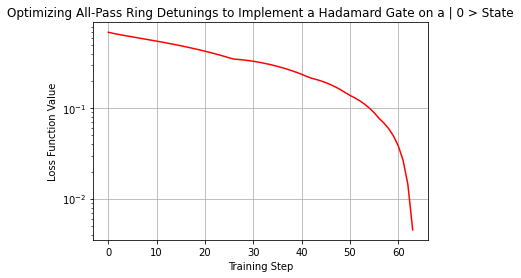

In [50]:
# Format data
Y = numpy.trim_zeros(Y)
X = numpy.linspace(0, len(Y)-1, len(Y))

# Print final information about optimization
print("Optimized rotation angles: {}".format(paramsNP))
print("Initial rotation angles: {}".format(paramsINIT))
print("Original Bloch Sphere Vector [Z Y X]: {}".format(circuit(init_params)))
print("Final Bloch Sphere Vector [Z Y X]: {}".format(circuit(params)))

difference = - paramsINIT + paramsNP
print()
print("Change in detunings: {}".format(difference))

# Plot graph of training progress
plt.figure(1)
plt.plot(X, Y, "-r", label="|\u03B1|^2")
plt.title("Optimizing All-Pass Ring Detunings to Implement a Hadamard Gate on a | 0 > State")
plt.xlabel("Training Step")
plt.ylabel("Loss Function Value")
plt.yscale('log', base=10, subs=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.xscale('linear')
plt.grid(True)
plt.show()